## Advanced DL and RL: Домашнее задание 2

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя.

Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

In [1]:
import gym
import sys
import random
import math
import numpy as np
import scipy as sp
from collections import defaultdict
from tqdm import tqdm
from operator import mul
from functools import reduce

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()

### Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

1.	Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [9]:
class QLearningStrategy:
    def __init__(self, alpha, gamma, eps):
        self.Q = defaultdict()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
    def __call__(self, state, actions, training=False):
        if state in self.Q and (training and np.random.random() > self.eps or not training):
            index = np.argmax(self.Q[state])
        else:
            index = np.random.randint(len(actions))
            if training and state not in self.Q:
                self.Q[state] = np.zeros(len(actions))
        return index  
        
    def update_Q(self, state, action, reward, next_state=None):
        if next_state is not None:
            current_Q = self.Q[state][action]
            next_Q = np.max(self.Q[next_state]) if next_state in self.Q else 0
            target_Q = reward + (self.gamma * next_Q)
            self.Q[state][action] = current_Q + self.alpha * (target_Q - current_Q)
        else:
            self.Q[state][action] = reward

    def getActionGreedy(self, state, n_actions):
        if state in self.Q:
            return np.argmax(self.Q[state])
        else:
            return np.random.randint(n_actions)
    
    def write_Q(self, state, action, reward):
        self.Q[state][action] = reward

In [16]:
def evaluate_strategy(env, pi_cross, pi_naught, total_episodes, verbose=False):
    total_reward = 0.0
    for i_episode in range(1, total_episodes + 1):
        if verbose:
            if i_episode % 100 == 0:
                print("\rEpisode {}/{}".format(i_episode, total_episodes), end="")
                sys.stdout.flush()

        reward = one_episode(env, pi_cross, pi_naught, False)
        total_reward = total_reward + reward 
        
    mean_reward = total_reward / total_episodes      
        
    return mean_reward

In [17]:
def one_episode(env, pi_cross, pi_naught, training=False):
    env.reset()
    reward = 0
    done = False

    board_state = env.getState()
    board_hash, empty_spaces, current_turn = board_state

    # training mode
    if training:
        state_cross = None
        action_cross_index = None
        state_naught = None 
        action_naught_index = None

        while not done:
            # crosses turn
            if (current_turn == 1):
                index = pi_cross(board_hash, empty_spaces, training)
                action_cross = empty_spaces[index]
                next_board_state, reward, done, info = env.step(action_cross)
                next_board_hash, next_empty_spaces, next_turn = next_board_state
            
                if (state_naught and action_naught_index) is not None:
                    # update Q table for naughts
                    pi_naught.update_Q(state_naught, action_naught_index, -reward, next_board_hash)

                if done and reward == 1:
                    # update Q table for crosses if they win on previous state
                    pi_cross.update_Q(board_hash, index, reward, None)

                state_cross = board_hash
                action_cross_index = index

            # naughts turn
            elif (current_turn == -1):
                index = pi_naught(board_hash, empty_spaces, training)
                action_naught = empty_spaces[index]
                next_board_state, reward, done, info = env.step(action_naught)
                next_board_hash, next_empty_spaces, next_turn = next_board_state

                if (state_cross and action_cross_index) is not None:
                    # update Q table for crosses
                    pi_cross.update_Q(state_cross, action_cross_index, reward, next_board_hash)

                if done and reward == -1:
                    # update Q table for naughts if they win on previous state
                    pi_naught.update_Q(board_hash, index, -reward, None)            

                state_naught = board_hash
                action_naught_index = index
            else:
                print('Please, check your environment!')

            board_hash, empty_spaces, current_turn = next_board_hash, next_empty_spaces, next_turn

    # battle mode
    else:
        while not done:
            # crosses turn
            if (current_turn == 1):
                # make a move based on the strategy
                if (pi_cross is not None):
                    index = pi_cross(board_hash, empty_spaces, training)
                else:
                    # random strategy
                    index = np.random.randint(len(empty_spaces))
                action_cross = empty_spaces[index]

                next_board_state, reward, done, info = env.step(action_cross)
                next_board_hash, next_empty_spaces, next_turn = next_board_state

            # naughts turn
            elif (current_turn == -1):
                # make a move based on the strategy
                if (pi_naught is not None):
                    index = pi_naught(board_hash, empty_spaces, training)
                else:
                    # random strategy
                    index = np.random.randint(len(empty_spaces))
                action_naught = empty_spaces[index]

                next_board_state, reward, done, info = env.step(action_naught)
                next_board_hash, next_empty_spaces, next_turn = next_board_state
            else:
                print('Please, check your environment!')

            board_hash, empty_spaces, current_turn = next_board_hash, next_empty_spaces, next_turn

    return reward

In [18]:
def q_learning_train(env, pi_cross, pi_naught, total_episodes, eval_episodes):
    crosses_rewards = []
    naughts_rewards = []
    crosses_trend = []
    naughts_trend = []    

    reward = 0
    for i_episode in tqdm(range(1, total_episodes + 1)):
        reward = one_episode(env, pi_cross, pi_naught, True)
       
        if i_episode % eval_episodes == 0:
            x_reward = evaluate_strategy(env, pi_cross, None, eval_episodes, False)
            o_reward = -evaluate_strategy(env, None, pi_naught, eval_episodes, False)
            crosses_rewards.append(x_reward)
            naughts_rewards.append(o_reward)
            crosses_trend.append((i_episode, x_reward))
            naughts_trend.append((i_episode, o_reward))
            
    return pi_cross, pi_naught, crosses_rewards, naughts_rewards, crosses_trend, naughts_trend

In [19]:
def plot_reward(data, label):
    plt.plot([x[0] for x in data], [y[1] for y in data], label=label)
    plt.xlabel('Episode')
    plt.ylabel('Avg. reward')
    plt.grid()
    plt.legend(loc='lower right')

In [ ]:
env = TicTacToe(3, 3, 3)
alpha = 1e-02
gamma = 1.0
eps = 0.25
total_episodes = 300000
eval_episodes = 1000

In [ ]:
x_pi = QLearningStrategy(alpha, gamma, eps)
o_pi = QLearningStrategy(alpha, gamma, eps)

In [ ]:
x_pi_trained, o_pi_trained, x_rewards, o_rewards, plot_x, plot_o = \
    q_learning_train(env, x_pi, o_pi, total_episodes, eval_episodes)

100%|██████████| 300000/300000 [07:22<00:00, 677.37it/s] 


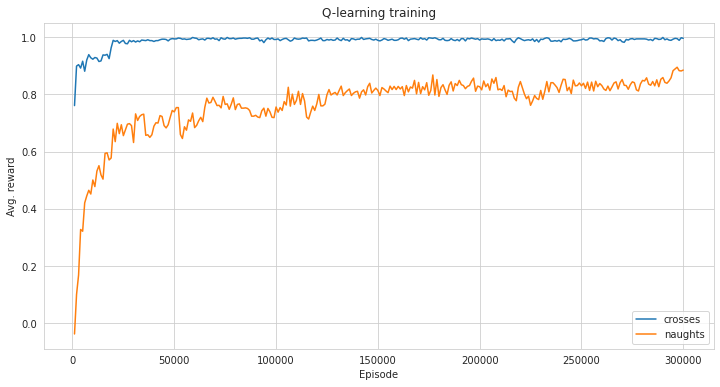

In [ ]:
plt.figure(figsize = (12, 6))
plot_reward(plot_x, 'crosses')
plot_reward(plot_o, 'naughts')
plt.title('Q-learning training');

In [ ]:
avg_x_ql_reward = evaluate_strategy(env, x_pi_trained, None, 10000, True)

Episode 10000/10000

In [ ]:
avg_o_ql_reward = -evaluate_strategy(env, None, o_pi_trained, 10000, True)

Episode 10000/10000

In [ ]:
print(f'Average crosses reward against naughts random strategy: {avg_x_ql_reward}')
print(f'Average naughts reward against crosses random strategy: {avg_o_ql_reward}')

Average crosses reward against noughts random strategy: 0.995
Average noughts reward against crosses random strategy: 0.8918


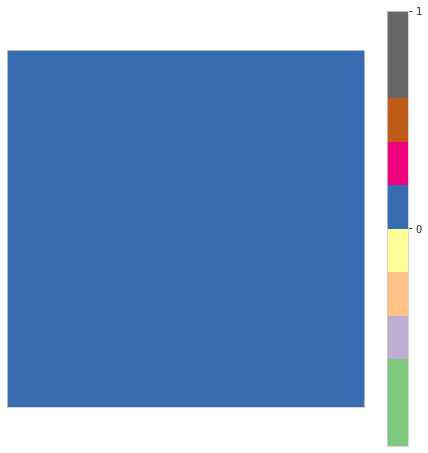

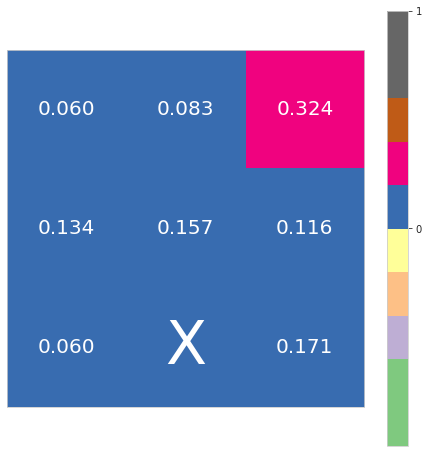

0 [0 0] 0.059778965494349356
1 [0 1] 0.0830879744018624
2 [0 2] 0.3235097711337574
3 [1 0] 0.13364820949010844
4 [1 1] 0.1574452820431656
5 [1 2] 0.11590856840378665
6 [2 0] 0.05991677898016406
7 [2 2] 0.17064125285541132


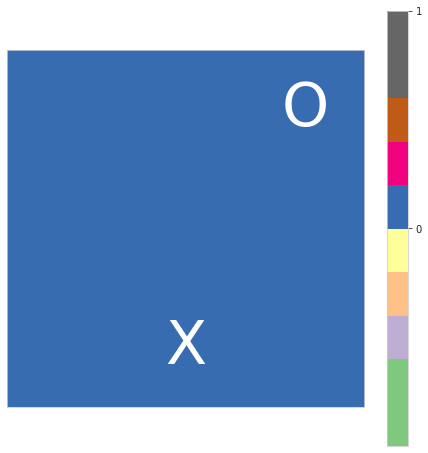

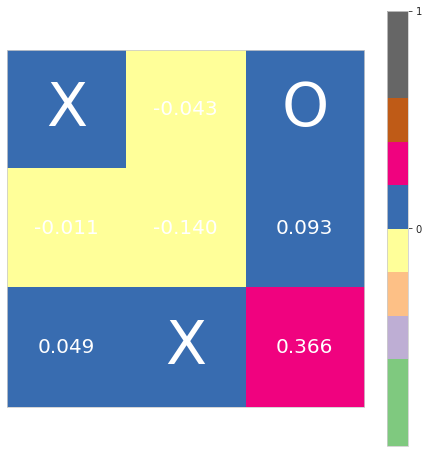

0 [0 1] -0.04254985225508775
1 [1 0] -0.010700655968624411
2 [1 1] -0.13980689895282547
3 [1 2] 0.09271950022456456
4 [2 0] 0.04942051206966396
5 [2 2] 0.36585681670780146


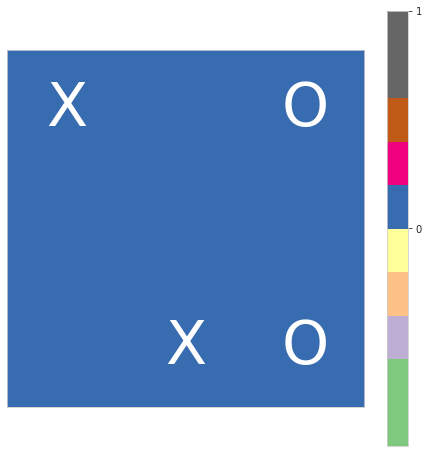

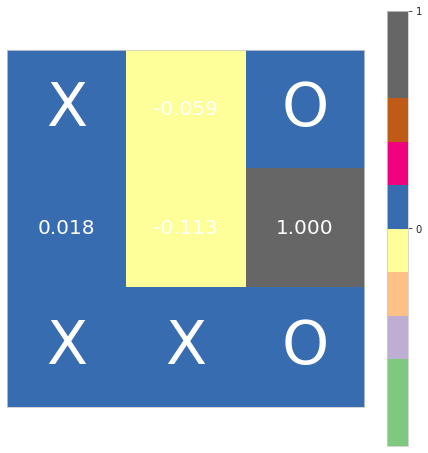

0 [0 1] -0.058519850599
1 [1 0] 0.017728592772576848
2 [1 1] -0.11343515625094397
3 [1 2] 1.0
Нолики выиграли!


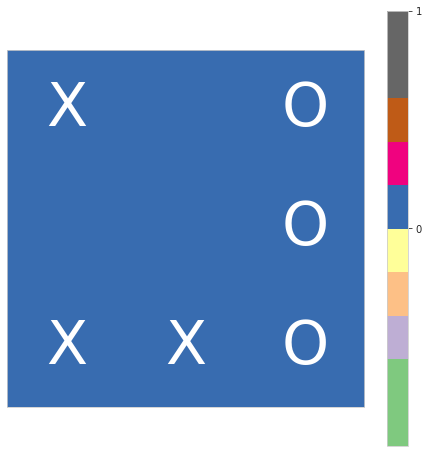

In [ ]:
plot_test_game(env, pi1=None, pi2=o_pi_trained, random_crosses=True, random_naughts=False)

2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5

Обучим стратегии крестиков и ноликов для доски 4х4. 

In [ ]:
env = TicTacToe(4, 4, 4)
alpha = 1e-02
gamma = 1.0
eps = 0.3
total_episodes = 1500000
eval_episodes = 1000

In [ ]:
x_pi_4 = QLearningStrategy(alpha, gamma, eps)
o_pi_4 = QLearningStrategy(alpha, gamma, eps)

In [ ]:
x_pi_trained_4, o_pi_trained_4, x_rewards_4, o_rewards_4, plot_x_4, plot_o_4 = \
    q_learning_train(env, x_pi_4, o_pi_4, total_episodes, eval_episodes)

100%|██████████| 1500000/1500000 [1:31:26<00:00, 273.42it/s]


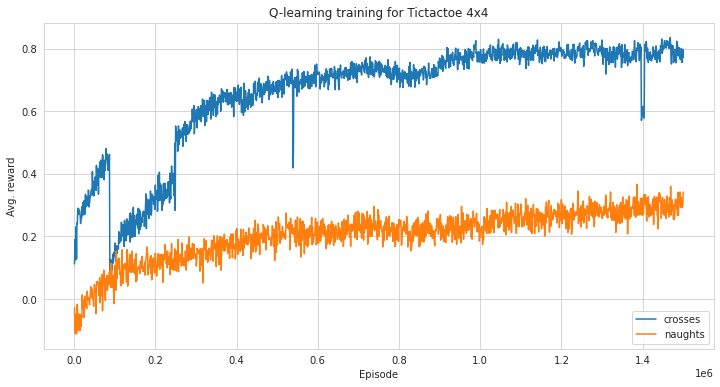

In [ ]:
plt.figure(figsize = (12, 6))
plot_reward(plot_x_4, 'crosses')
plot_reward(plot_o_4, 'naughts')
plt.title('Q-learning training for Tictactoe 4x4');

In [ ]:
avg_x_ql_reward_4 = evaluate_strategy(env, x_pi_trained_4, None, 10000, True)

Episode 10000/10000

In [ ]:
avg_o_ql_reward_4 = -evaluate_strategy(env, None, o_pi_trained_4, 10000, True)

Episode 10000/10000

In [ ]:
print(f'Average crosses reward against naughts random strategy: {avg_x_ql_reward_4}')
print(f'Average naughts reward against crosses random strategy: {avg_o_ql_reward_4}')

Average crosses reward against naughts random strategy: 0.7811
Average naughts reward against crosses random strategy: 0.3241


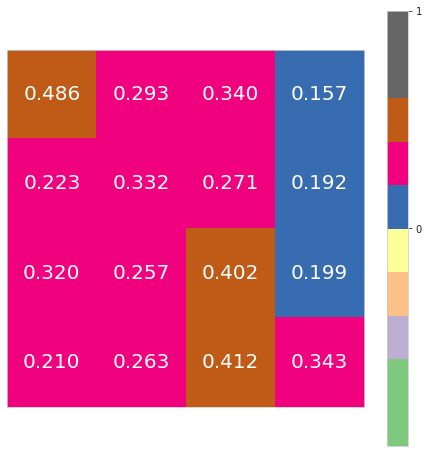

0 [0 0] 0.486239989100356
1 [0 1] 0.29312173544762754
2 [0 2] 0.3397101416591177
3 [0 3] 0.15670265606590178
4 [1 0] 0.22279607255636502
5 [1 1] 0.33164665063217175
6 [1 2] 0.27086606474614594
7 [1 3] 0.19223138410451704
8 [2 0] 0.320309741173339
9 [2 1] 0.2568737762546919
10 [2 2] 0.4018643535274659
11 [2 3] 0.19929301527400656
12 [3 0] 0.210420447669751
13 [3 1] 0.26306642484884546
14 [3 2] 0.41222219419942924
15 [3 3] 0.34266316673322267


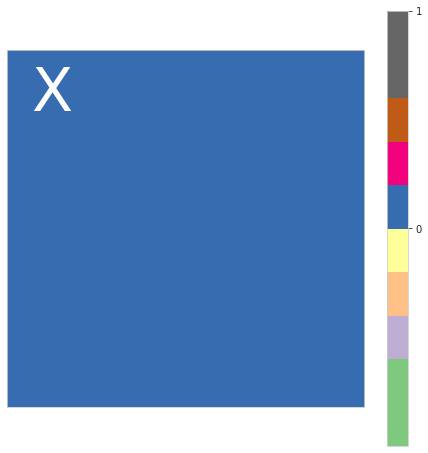

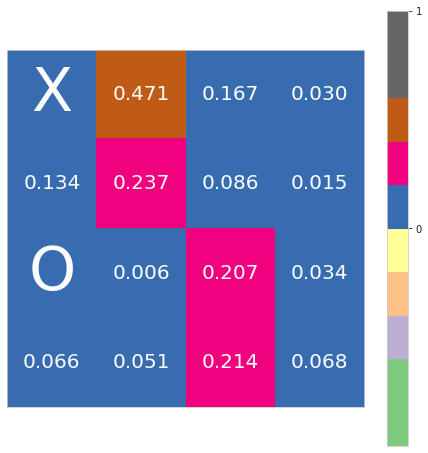

0 [0 1] 0.47144966403914385
1 [0 2] 0.16656496403737575
2 [0 3] 0.02979604750274702
3 [1 0] 0.13403119101460148
4 [1 1] 0.23744264940714038
5 [1 2] 0.08585181818540207
6 [1 3] 0.01480189693167643
7 [2 1] 0.006308755659868271
8 [2 2] 0.20654101033586467
9 [2 3] 0.03437374730130455
10 [3 0] 0.06597194576757849
11 [3 1] 0.05123845349700653
12 [3 2] 0.21365857050503323
13 [3 3] 0.06820603709174544


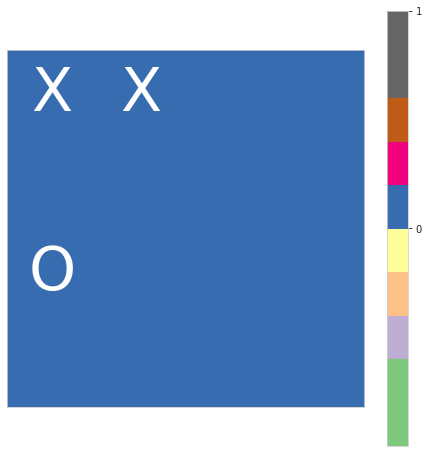

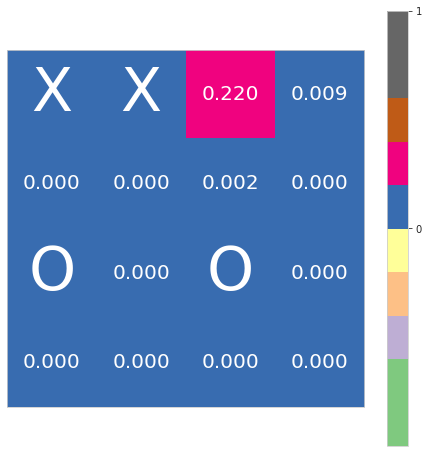

0 [0 2] 0.21960438230158325
1 [0 3] 0.00943650821978885
2 [1 0] 0.00010176475991874122
3 [1 1] 2.046699218860266e-05
4 [1 2] 0.0015196854896057381
5 [1 3] 3.643443018468572e-07
6 [2 1] 6.343389245506367e-05
7 [2 3] 3.804719137497503e-08
8 [3 0] 1.4381752567584592e-08
9 [3 1] 1.8441757064164903e-05
10 [3 2] 0.0
11 [3 3] 8.727187021863142e-05


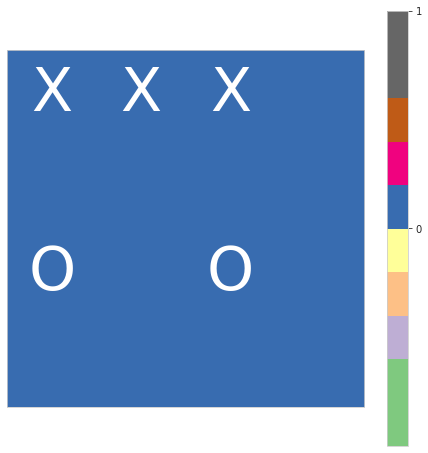

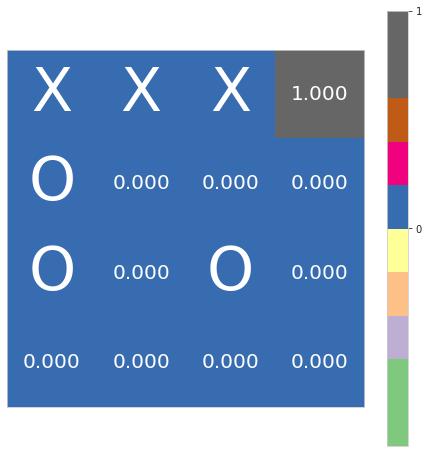

0 [0 3] 1.0
1 [1 1] 0.0
2 [1 2] 0.0
3 [1 3] 0.0
4 [2 1] 0.0
5 [2 3] 0.0
6 [3 0] 0.0
7 [3 1] 0.0
8 [3 2] 0.0
9 [3 3] 0.0
Крестики выиграли!


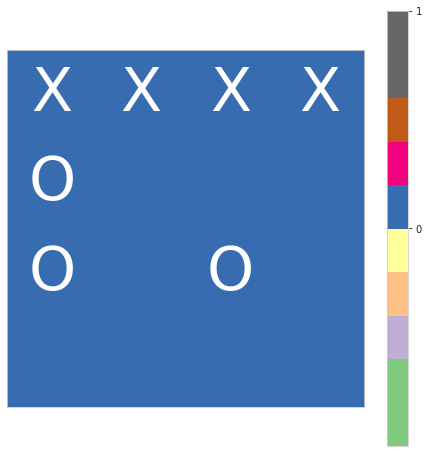

In [ ]:
plot_test_game(env, pi1=x_pi_trained_4, pi2=None, random_crosses=False, random_naughts=True)

Из полученных графиков и численных результатов видно, что:


1.   Качество обучения при игре за крестики растет быстрее. Вероятно, это связано с
тем, что крестики ходят первыми и за счет этого имеют приемущество при игре против случайной стратегии.
2.   Обучение на доске 4х4 занимает (ожидаемо) больше времени, поскольку различных вариантов ходов на такой доске больше, чем в случае с 3х3. 




### Часть вторая: добавим нейронных сетей



Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [ ]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [ ]:
class Network_3(nn.Module):
    def __init__(self, layer_size=128):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(3, layer_size * 2, 3)
        self.l1 = nn.Linear(layer_size * 2, layer_size)
        self.l2 = nn.Linear(layer_size, 9)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
class TicTacToeDQN():
    def __init__(self, env, model_class=Network_3, mem_size=10000, 
                 learning_rate=0.001, gamma=0.8, batch_size=64, 
                 eps_init=0.9, eps_final=0.05, eps_decay=200):
        
        self.env = env
        self.model_crosses = model_class().to(device)
        self.model_naughts = model_class().to(device)
        self.memory_crosses = ReplayMemory(mem_size)
        self.memory_naughts = ReplayMemory(mem_size)
        self.optimizer_crosses = optim.Adam(self.model_crosses.parameters(), learning_rate, weight_decay=0.001)
        self.optimizer_naughts = optim.Adam(self.model_naughts.parameters(), learning_rate, weight_decay=0.001)
        self.state_cross = None
        self.action_cross_index = None
        self.state_naughts = None
        self.action_naughts_index = None
        
        self.gamma = gamma
        self.batch_size = batch_size
        
        self.eps_init, self.eps_final, self.eps_decay = eps_init, eps_final, eps_decay
        self.num_step = 0

    def select_greedy_action(self, state, model):
        return model(state.unsqueeze(0)).data.max(1)[1].view(1, 1)

    def select_action(self, state, model):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, model)
        else:
            return torch.tensor([[random.randrange(self.env.n_rows * self.env.n_cols)]], dtype=torch.int64)

    def hash_to_tensor(self, board_hash):
        board_hash = np.array([int(digit) for digit in board_hash])
        board_hash_mat = np.zeros((3, len(board_hash)))
        board_hash_mat[board_hash, np.arange(len(board_hash))] = 1
        board_hash_mat = np.roll(board_hash_mat, 1, 0)
        return torch.tensor(board_hash_mat.reshape(3, env.n_rows, env.n_cols)).to(torch.float32) 

    def run_episode(self, do_learning=True, greedy=False):
        self.env.reset()
        self.state_cross = None
        self.action_cross_index = None
        self.state_naughts = None
        self.action_naughts_index = None

        board_state = env.getState()
        board_hash, _, current_turn = board_state
        while True:
            board_state_tensor = self.hash_to_tensor(board_hash)

            if current_turn == 1:

                with torch.no_grad():
                    if greedy:
                        index = self.select_greedy_action(board_state_tensor.to(device), self.model_crosses).cpu()
                    else:
                        index = self.select_action(board_state_tensor.to(device), self.model_crosses).cpu()

                self.state_cross = board_state_tensor
                self.action_cross_index = index
                action = self.env.action_from_int(index.numpy()[0][0])

                next_board_state, reward, done, info = self.env.step(action)
                next_board_hash, next_empty_spaces, next_turn = next_board_state
                next_board_state_tensor = self.hash_to_tensor(next_board_hash)
            
                transition = ()
                if reward == -10:
                    transition = (board_state_tensor, 
                                  index, 
                                  next_board_state_tensor, 
                                  torch.tensor([reward], dtype=torch.float32))
                    self.memory_crosses.store(transition)
                else:
                    if self.state_naughts is not None:
                        if reward == 1:
                            transition = (self.state_cross, 
                                          self.action_cross_index,
                                          next_board_state_tensor,
                                          torch.tensor([1.0], dtype=torch.float32))
                            self.memory_crosses.store(transition)

                        transition = (self.state_naughts,
                                      self.action_naughts_index, 
                                      next_board_state_tensor,
                                      torch.tensor([reward * -1], dtype=torch.float32))
                        self.memory_naughts.store(transition)

                if do_learning:
                    if (current_turn == next_turn):
                        self.learn(self.model_crosses, self.memory_crosses, self.optimizer_crosses)
                    else:
                        self.learn(self.model_naughts, self.memory_naughts, self.optimizer_naughts)

            elif (current_turn == -1):

                with torch.no_grad():
                    if greedy:
                        index = self.select_greedy_action(board_state_tensor.to(device), self.model_naughts).cpu()
                    else:
                        index = self.select_action(board_state_tensor.to(device), self.model_naughts).cpu()

                self.state_naughts = board_state_tensor
                self.action_naughts_index = index
                action = self.env.action_from_int(index.numpy()[0][0])

                next_board_state, reward, done, info = self.env.step(action)
                next_board_hash, next_empty_spaces, next_turn = next_board_state
                next_board_state_tensor = self.hash_to_tensor(next_board_hash)

                transition = ()
                if reward == -10:
                    transition = (board_state_tensor, 
                                  index, 
                                  next_board_state_tensor, 
                                  torch.tensor([reward], dtype=torch.float32))
                    self.memory_naughts.store(transition)
                else:
                    if self.state_cross is not None:
                        if reward == -1:
                            transition = (self.state_naughts, 
                                          self.action_naughts_index, 
                                          next_board_state_tensor,
                                          torch.tensor([1.0], dtype=torch.float32))
                            self.memory_naughts.store(transition)

                        transition = (self.state_cross, 
                                      self.action_cross_index, 
                                      next_board_state_tensor, 
                                      torch.tensor([reward], dtype=torch.float32))
                        self.memory_crosses.store(transition)

                if do_learning:
                    if (current_turn == next_turn):
                        self.learn(self.model_naughts, self.memory_naughts, self.optimizer_naughts)
                    else:
                        self.learn(self.model_crosses, self.memory_crosses, self.optimizer_crosses)         

            board_hash, current_turn = next_board_hash, next_turn

            if done:
                break

    def learn(self, model, memory, optimizer):
        if min(len(self.memory_crosses), len(self.memory_naughts)) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.stack(batch_state).to(device))
        batch_action = Variable(torch.cat(batch_action).to(device))
        batch_reward = Variable(torch.cat(batch_reward).to(device))
        batch_next_state = Variable(torch.stack(batch_next_state).to(device))

        # считаем значения функции Q
        Q = model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
def dqn_evaluate(strategy, player='crosses', eval_episodes=1000):
    rewards = []
    wins = 0.0
    losses = 0.0

    for i_episode in range(eval_episodes):
        strategy.env.reset()
            
        board_state = strategy.env.getState()
        board_hash, empty_spaces, current_turn = board_state
        done = False
        while not done:
            if player == 'crosses':
                if current_turn == 1:
                    index = strategy.select_greedy_action(strategy.hash_to_tensor(board_hash).to(device), strategy.model_crosses).cpu()
                    action = strategy.env.action_from_int(index)
                else:
                    index = np.random.randint(len(empty_spaces))
                    action = empty_spaces[index]
            else:
                if current_turn == -1:
                    index = strategy.select_greedy_action(strategy.hash_to_tensor(board_hash).to(device), strategy.model_naughts)
                    action = strategy.env.action_from_int(index)
                else:
                    index = np.random.randint(len(empty_spaces))
                    action = empty_spaces[index]

            next_board_state, reward, done, info = strategy.env.step(action)
            next_board_hash, next_empty_spaces, next_turn = next_board_state

            board_hash, empty_spaces, current_turn = next_board_hash, next_empty_spaces, next_turn

        if reward != -10 and player == 'naughts':
            reward = reward * -1
        rewards.append(reward)

    wins = rewards.count(1) / eval_episodes
    losses = rewards.count(-1) / eval_episodes
    
    return wins, losses

In [ ]:
def dqn_train(strategy, total_episodes, eval_episodes):
    crosses_wins = []
    crosses_losses = []
    naughts_wins = [] 
    naughts_losses = []
    episodes = []

    reward = 0.0
    for i_episode in tqdm(range(1, total_episodes + 1)):
        strategy.run_episode(do_learning=True)
       
        if i_episode % eval_episodes == 0:
            x_wins, x_losses = dqn_evaluate(strategy, 'crosses', eval_episodes)
            o_wins, o_losses = dqn_evaluate(strategy, 'naughts', eval_episodes)

            crosses_wins.append(x_wins)
            crosses_losses.append(x_losses)
            naughts_wins.append(o_wins)
            naughts_losses.append(o_losses)
            episodes.append(i_episode)

    return crosses_wins, crosses_losses, naughts_wins, naughts_losses, episodes

In [ ]:
def plot_reward(data, label):
    plt.plot([x[0] for x in data], [y[1] for y in data], label=label)
    plt.xlabel('Episode')
    plt.ylabel('Avg. reward')
    plt.grid()
    plt.legend(loc='upper left')

In [ ]:
env = TicTacToe(3, 3, 3)
total_episodes = 30000
eval_episodes = 1000

In [ ]:
DQN = TicTacToeDQN(env, Network_3, mem_size=100000, 
                   learning_rate=1e-4, gamma=0.8, 
                   batch_size=512, eps_init=0.9, eps_decay=100000)

In [ ]:
x_wins, x_losses, o_wins, o_losses, n_episode = dqn_train(DQN, total_episodes, eval_episodes)

Выходные данные были обрезаны до нескольких последних строк (5000).

 91%|█████████ | 27192/30000 [15:44<01:33, 29.90it/s]






 91%|█████████ | 27196/30000 [15:44<01:33, 30.14it/s]






 91%|█████████ | 27200/30000 [15:44<01:29, 31.32it/s]






 91%|█████████ | 27204/30000 [15:44<01:27, 31.96it/s]






 91%|█████████ | 27208/30000 [15:44<01:28, 31.62it/s]






 91%|█████████ | 27212/30000 [15:45<01:26, 32.09it/s]






 91%|█████████ | 27216/30000 [15:45<01:24, 33.00it/s]






 91%|█████████ | 27220/30000 [15:45<01:25, 32.56it/s]






 91%|█████████ | 27224/30000 [15:45<01:30, 30.55it/s]






 91%|█████████ | 27228/30000 [15:45<01:28, 31.36it/s]






 91%|█████████ | 27232/30000 [15:45<01:30, 30.53it/s]






 91%|█████████ | 27236/30000 [15:45<01:29, 30.93it/s]






 91%|█████████ | 27240/30000 [15:46<01:29, 30.77it/s]






 91%|█████████ | 27244/30000 [15:46<01:28, 31.27it/s]






 91%|█████████ | 27248/30000 [15:46<01:27, 31.58it/s]






 91%|█████████ | 27252/30000 [1

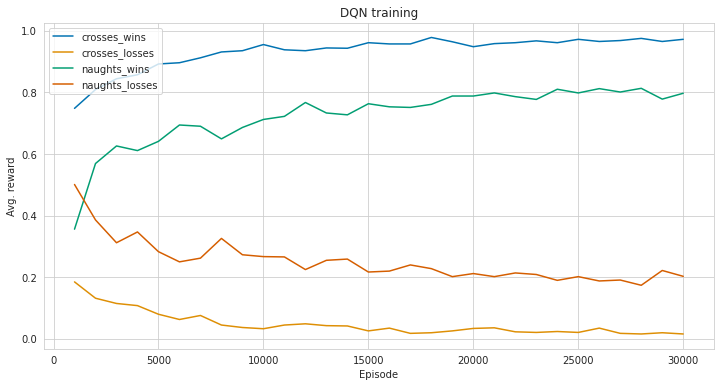

In [ ]:
plt.figure(figsize = (12, 6))
plot_reward(list(zip(n_episode, x_wins)), 'crosses_wins')
plot_reward(list(zip(n_episode, x_losses)), 'crosses_losses')
plot_reward(list(zip(n_episode, o_wins)), 'naughts_wins')
plot_reward(list(zip(n_episode, o_losses)), 'naughts_losses')
plt.title('DQN training');

DQN для доски 4х4.

In [ ]:
class Network_4(nn.Module):
    def __init__(self, layer_size=128):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, layer_size // 4, 3)
        self.conv2 = nn.Conv2d(layer_size // 4, layer_size * 2, 2)
        self.l1 = nn.Linear(layer_size * 2, layer_size)
        self.l2 = nn.Linear(layer_size, 16)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [ ]:
env = TicTacToe(4, 4, 4)
total_episodes = 50000
eval_episodes = 1000

In [ ]:
DQN_4 = TicTacToeDQN(env, Network_4, mem_size=1000000, 
                   learning_rate=1e-4, gamma=0.8, 
                   batch_size=512, eps_init=0.9, eps_decay=100000)

In [ ]:
x_wins_4, x_losses_4, o_wins_4, o_losses_4, n_episode_4 = dqn_train(DQN_4, total_episodes, eval_episodes)

100%|██████████| 50000/50000 [1:28:49<00:00,  9.38it/s]


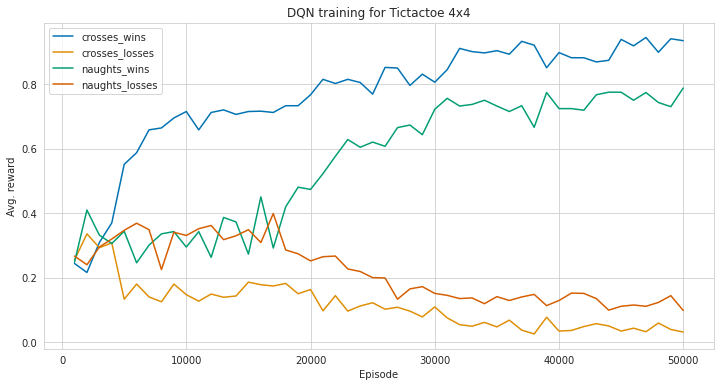

In [ ]:
plt.figure(figsize = (12, 6))
plot_reward(list(zip(n_episode_4, x_wins_4)), 'crosses_wins')
plot_reward(list(zip(n_episode_4, x_losses_4)), 'crosses_losses')
plot_reward(list(zip(n_episode_4, o_wins_4)), 'naughts_wins')
plot_reward(list(zip(n_episode_4, o_losses_4)), 'naughts_losses')
plt.title('DQN training for Tictactoe 4x4');

4.	Реализуйте Double DQN и/или Dueling DQN

Реализуем Dueling DQN.

In [ ]:
class Network_3_Dueling(nn.Module):
    def __init__(self, layer_size=128):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(3, layer_size * 2, 3)
        self.fc = nn.Linear(layer_size * 2, layer_size)
        self.adv = nn.Linear(layer_size, 9)
        self.val = nn.Linear(layer_size, 1)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc(x))
        a = self.adv(x)
        v = self.val(x)
        x = v + a - torch.mean(a, dim=1, keepdim=True)
        return x

In [ ]:
env = TicTacToe(3, 3, 3)
total_episodes = 30000
eval_episodes = 1000

In [ ]:
DQN_duel = TicTacToeDQN(env, Network_3_Dueling, mem_size=100000, 
                   learning_rate=1e-4, gamma=0.8, 
                   batch_size=512, eps_init=0.9, eps_decay=100000)

In [ ]:
x_wins_duel, x_losses_duel, o_wins_duel, \
    o_losses_duel, n_episode_duel = dqn_train(DQN_duel, total_episodes, eval_episodes)

Выходные данные были обрезаны до нескольких последних строк (5000).

 92%|█████████▏| 27700/30000 [18:35<01:29, 25.74it/s]






 92%|█████████▏| 27703/30000 [18:35<01:28, 26.00it/s]






 92%|█████████▏| 27706/30000 [18:35<01:30, 25.36it/s]






 92%|█████████▏| 27709/30000 [18:35<01:33, 24.63it/s]






 92%|█████████▏| 27712/30000 [18:35<01:31, 24.92it/s]






 92%|█████████▏| 27715/30000 [18:36<01:28, 25.75it/s]






 92%|█████████▏| 27718/30000 [18:36<01:27, 26.11it/s]






 92%|█████████▏| 27721/30000 [18:36<01:29, 25.40it/s]






 92%|█████████▏| 27724/30000 [18:36<01:29, 25.34it/s]






 92%|█████████▏| 27727/30000 [18:36<01:33, 24.19it/s]






 92%|█████████▏| 27730/30000 [18:36<01:30, 25.19it/s]






 92%|█████████▏| 27733/30000 [18:36<01:27, 26.03it/s]






 92%|█████████▏| 27736/30000 [18:36<01:30, 25.07it/s]






 92%|█████████▏| 27739/30000 [18:37<01:32, 24.55it/s]






 92%|█████████▏| 27743/30000 [18:37<01:26, 26.11it/s]






 92%|█████████▏| 27747/30000 [1

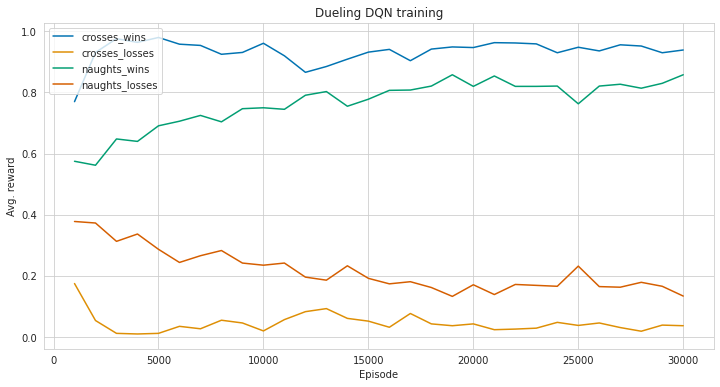

In [ ]:
plt.figure(figsize = (12, 6))
plot_reward(list(zip(n_episode_duel, x_wins_duel)), 'crosses_wins')
plot_reward(list(zip(n_episode_duel, x_losses_duel)), 'crosses_losses')
plot_reward(list(zip(n_episode_duel, o_wins_duel)), 'naughts_wins')
plot_reward(list(zip(n_episode_duel, o_losses_duel)), 'naughts_losses')
plt.title('Dueling DQN training');

Dueling DQN для доски 4х4.

In [ ]:
class Network_4_Dueling(nn.Module):
    def __init__(self, layer_size=128):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, layer_size // 4, 3)
        self.conv2 = nn.Conv2d(layer_size // 4, layer_size * 2, 2)
        self.fc = nn.Linear(layer_size * 2, layer_size)
        self.adv = nn.Linear(layer_size, 16)
        self.val = nn.Linear(layer_size, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc(x))
        a = self.adv(x)
        v = self.val(x)
        x = v + a - torch.mean(a, dim=1, keepdim=True)
        return x

In [ ]:
env = TicTacToe(4, 4, 4)
total_episodes = 40000
eval_episodes = 1000

In [ ]:
DQN_duel_4 = TicTacToeDQN(env, Network_4_Dueling, mem_size=1000000, 
                          learning_rate=1e-4, gamma=0.8, 
                          batch_size=512, eps_init=0.9, eps_decay=100000)

In [ ]:
x_wins_duel_4, x_losses_duel_4, o_wins_duel_4, o_losses_duel_4, \
    n_episode_duel_4 = dqn_train(DQN_duel_4, total_episodes, eval_episodes)

100%|██████████| 40000/40000 [1:23:31<00:00,  7.98it/s]


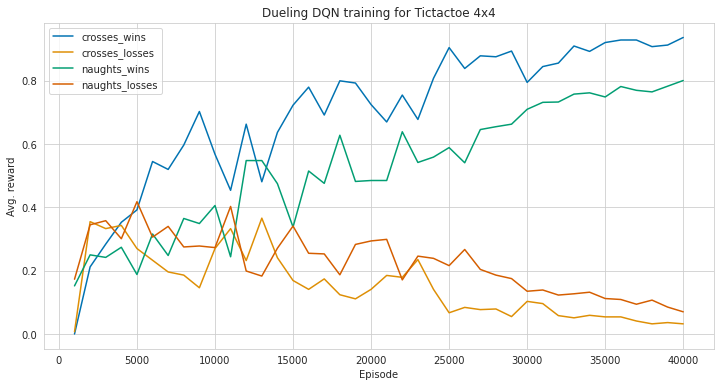

In [ ]:
plt.figure(figsize = (12, 6))
plot_reward(list(zip(n_episode_duel_4, x_wins_duel_4)), 'crosses_wins')
plot_reward(list(zip(n_episode_duel_4, x_losses_duel_4)), 'crosses_losses')
plot_reward(list(zip(n_episode_duel_4, o_wins_duel_4)), 'naughts_wins')
plot_reward(list(zip(n_episode_duel_4, o_losses_duel_4)), 'naughts_losses')
plt.title('Dueling DQN training for Tictactoe 4x4');

Таким образом, удалось провести обучение DQN и Dueling DQN на досках 3х3 и 4х4. В сравнении с табличным Q обучением нам требуется меньше эпизодов для сходимости решения. При этом потребность в вычислительных ресурсах возрастает.

### Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.

5.	Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

In [7]:
from copy import deepcopy

In [176]:
def rollout(env, action, pi_cross, pi_naught):
    rollout_env = deepcopy(env)
    done = False

    board_state, reward, done, info = rollout_env.step(action)
    board_hash, empty_spaces, current_turn = board_state

    while not done:
        # crosses turn
        if (current_turn == 1):
            # make a move based on the strategy
            if (pi_cross is not None):
                index = pi_cross(board_hash, empty_spaces, training)
            else:
                # random strategy
                index = np.random.randint(len(empty_spaces))
            action_cross = empty_spaces[index]

            next_board_state, reward, done, info = rollout_env.step(action_cross)
            next_board_hash, next_empty_spaces, next_turn = next_board_state

        # naughts turn
        elif (current_turn == -1):
            # make a move based on the strategy
            if (pi_naught is not None):
                index = pi_naught(board_hash, empty_spaces, training)
            else:
                # random strategy
                index = np.random.randint(len(empty_spaces))
            action_naught = empty_spaces[index]

            next_board_state, reward, done, info = rollout_env.step(action_naught)
            next_board_hash, next_empty_spaces, next_turn = next_board_state
        else:
            print('Something went wrong!')
        board_hash, empty_spaces, current_turn = next_board_hash, next_empty_spaces, next_turn       
    
    return reward
        
def use_rollout_action(env, empty_spaces, pi_cross=None, pi_naught=None, n_rollouts=20):
    best_index = 0
    best_reward = -np.inf
    for index, action in enumerate(empty_spaces):
        rewards = []
        for _ in range(n_rollouts):
            reward = rollout(env, action, pi_cross, pi_naught)
            rewards.append(reward)
        mean_reward = np.array(rewards).mean()

        _, _, current_turn = env.getState()
        if (current_turn == -1):
            mean_reward = mean_reward * -1

        if mean_reward > best_reward:
            best_reward = mean_reward
            best_index = index

    return best_index

def play_with_rollouts(env, pi_cross=None, pi_naught=None, 
                       pi_cross_use_rollout=True, 
                       pi_naught_use_rollout=False, 
                       n_rollouts=20):
    env.reset()
    reward = 0
    done = False

    board_state = env.getState()
    board_hash, empty_spaces, current_turn = board_state

    while not done:
        # crosses turn
        if current_turn == 1:
            if (pi_cross_use_rollout):
                index = use_rollout_action(env, empty_spaces, pi_cross, None, n_rollouts)
            else:
                index = np.random.randint(len(empty_spaces))

            action_cross = empty_spaces[index]
            next_board_state, reward, done, info = env.step(action_cross)
            next_board_hash, next_empty_spaces, next_turn = next_board_state
            
        # naughts turn
        elif current_turn == -1:
            if (pi_naught_use_rollout):
                index = use_rollout_action(env, empty_spaces, None, pi_naught, n_rollouts)
            else:
                index = np.random.randint(len(empty_spaces))

            action_naught = empty_spaces[index]
            next_board_state, reward, done, info = env.step(action_naught)
            next_board_hash, next_empty_spaces, next_turn = next_board_state
        else:
            print('Please, check your environment!')

        board_hash, empty_spaces, current_turn = next_board_hash, next_empty_spaces, next_turn

    return reward

def evaluate_reward_with_rollouts(env, pi_cross=None, pi_naught=None,
                                  pi_cross_use_rollout=True, 
                                  pi_naught_use_rollout=False,                                   
                                  total_episodes=1000, n_rollouts=20):
    rewards = []
    for i_episode in tqdm(range(1, total_episodes + 1)):
        reward = play_with_rollouts(env, pi_cross, pi_naught, pi_cross_use_rollout, pi_naught_use_rollout)
        rewards.append(reward)

    x_wins = rewards.count(1) / total_episodes
    o_wins = rewards.count(-1) / total_episodes    
    draw = rewards.count(0) / total_episodes   

    return rewards, x_wins, o_wins, draw

Крестики со случайной стратегией и возможностью rollout против случайной стратегии ноликов.

In [167]:
env = TicTacToe(3, 3, 3)
total_episodes = 200
n_rollouts = 20
pi_cross = None
pi_naught = None
pi_cross_use_rollout = True
pi_naught_use_rollout = False

In [168]:
rewards, wins, losses, draws = evaluate_reward_with_rollouts(env, pi_cross, pi_naught, 
                                                             pi_cross_use_rollout, 
                                                             pi_naught_use_rollout, 
                                                             total_episodes, n_rollouts)















  0%|          | 0/200 [00:00<?, ?it/s]













  0%|          | 1/200 [00:00<00:44,  4.43it/s]













  1%|          | 2/200 [00:00<00:43,  4.54it/s]













  2%|▏         | 3/200 [00:00<00:42,  4.69it/s]













  2%|▏         | 4/200 [00:00<00:40,  4.90it/s]













  2%|▎         | 5/200 [00:01<00:39,  4.99it/s]













  3%|▎         | 6/200 [00:01<00:39,  4.91it/s]













  4%|▎         | 7/200 [00:01<00:39,  4.84it/s]













  4%|▍         | 8/200 [00:01<00:39,  4.89it/s]













  4%|▍         | 9/200 [00:01<00:37,  5.04it/s]













  5%|▌         | 10/200 [00:01<00:36,  5.19it/s]













  6%|▌         | 11/200 [00:02<00:36,  5.11it/s]













  6%|▌         | 12/200 [00:02<00:36,  5.11it/s]













  6%|▋         | 13/200 [00:02<00:36,  5.10it/s]













  7%|▋         | 14/200 [00:02<00:35,  5.18it/s]













  8%|▊         | 15/200 [00:02<00:36,  5.02it/s]













  8%|▊      

In [172]:
print(f'X wins: {wins}, O wins: {losses}, draws: {draws}')

X wins: 0.99, O wins: 0.0, draws: 0.01


Крестики со случайной стратегией против случайной стратегии ноликов с возможностью делать rollout.

In [173]:
env = TicTacToe(3, 3, 3)
total_episodes = 200
n_rollouts = 20
pi_cross = None
pi_naught = None
pi_cross_use_rollout = False
pi_naught_use_rollout = True

In [174]:
rewards, wins, losses, draws = evaluate_reward_with_rollouts(env, pi_cross, pi_naught, 
                                                             pi_cross_use_rollout, 
                                                             pi_naught_use_rollout, 
                                                             total_episodes, n_rollouts)















  0%|          | 0/200 [00:00<?, ?it/s]













  0%|          | 1/200 [00:00<00:31,  6.37it/s]













  1%|          | 2/200 [00:00<00:30,  6.42it/s]













  2%|▏         | 3/200 [00:00<00:29,  6.57it/s]













  2%|▏         | 4/200 [00:00<00:30,  6.41it/s]













  2%|▎         | 5/200 [00:00<00:30,  6.33it/s]













  3%|▎         | 6/200 [00:00<00:28,  6.80it/s]













  4%|▎         | 7/200 [00:01<00:29,  6.62it/s]













  4%|▍         | 8/200 [00:01<00:29,  6.56it/s]













  4%|▍         | 9/200 [00:01<00:29,  6.55it/s]













  5%|▌         | 10/200 [00:01<00:27,  6.88it/s]













  6%|▌         | 11/200 [00:01<00:27,  6.79it/s]













  6%|▌         | 12/200 [00:01<00:27,  6.79it/s]













  6%|▋         | 13/200 [00:01<00:26,  7.18it/s]













  7%|▋         | 14/200 [00:02<00:25,  7.16it/s]













  8%|▊         | 15/200 [00:02<00:26,  7.08it/s]













  8%|▊      

In [175]:
print(f'X wins: {wins}, O wins: {losses}, draws: {draws}')

X wins: 0.075, O wins: 0.845, draws: 0.08


Из полученных результатов видно, что возможность 'заглянуть вперед' дает нам существенное преимущество даже при использовании случайной стратегии. При этом, для такой несложной игры как Крестики-нолики не требуется применение больших вычислительных мощностей.